In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchtext
from torchtext import data
from torchtext import datasets
import collections
import math
import numpy as np

In [2]:
import re
import spacy
import string
from nltk.stem.porter import *
stemmer = PorterStemmer()
import nltk
from nltk.corpus import stopwords
stopword_lst = set(stopwords.words('english'))

nlp = spacy.load('en')
MAX_CHARS = 20000
def tokenizer(comment):
    comment = comment.lower()
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;#]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\,+", ",", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    return [x.text for x in nlp.tokenizer(comment) if x.text != " "]

def tfidftokenizer(comment):
    comment = comment.lower()
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;#.]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\,+", "", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    return [stemmer.stem(x.text) for x in nlp.tokenizer(comment) \
            if x.text != " " and x.text not in string.punctuation and x.text not in stopword_lst]

def segment_embedding(comment):
    comment = comment.lower()
    comment = re.sub(r"[\*\"“”\n\\…\+\-\/\=\(\)‘•:\[\]\|’;#.]", " ", str(comment))
    comment = re.sub(r"[ ]+", " ", comment)
    comment = re.sub(r"\,+", "", comment)
    if (len(comment) > MAX_CHARS):
        comment = comment[:MAX_CHARS]
    word_lst = [stemmer.stem(x.text) for x in nlp.tokenizer(comment) \
            if x.text != " " and x.text not in string.punctuation and x.text not in stopword_lst]
    seg_embedding = np.zeros(200)
    for w in word_lst:
        if w in embedding.stoi:
            seg_embedding += np.array(embedding.vectors[embedding.stoi[w]])
    return seg_embedding/len(seg_embedding)

In [3]:
import csv
segs_lst = []
with open('data/csv/train/boots.csv', 'r') as f:
    csvReader = csv.reader(f)
    next(csvReader)
    for line in csvReader:
        id_, rating, text, _ = line
        segs = text.split(" EDU_BREAK ")
        for s in segs:
            segs_lst.append(" ".join(tfidftokenizer(s)))
tmp = []
with open('data/gold/aspects/boots-dev.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                segs_lst.append(" ".join(tfidftokenizer(text)))
            tmp = []
tmp = []   
with open('data/gold/aspects/boots-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                segs_lst.append(" ".join(tfidftokenizer(text)))
            tmp = []


In [4]:
embedding = torchtext.vocab.Vectors('boots.200d.txt')
if torch.cuda.is_available():
    torch.cuda.set_device(2)
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

 94%|█████████▍| 16529/17585 [00:01<00:00, 14138.73it/s]


In [5]:
class AspectNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        for param in self.embedding.parameters():
            param.requires_grad = False
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        
        logits = self.fc(cat)
        
        probs = F.softmax(logits, dim=1)
        
        classes = torch.max(logits, 1)[1]
            
        return probs, classes


In [6]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        for param in self.embedding.parameters():
            param.requires_grad = False
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        #self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        #self.apply(init_weights)
        
    def forward(self, text):
        
        #text = [sent len, batch size]
        
        text = text.permute(1, 0)
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
        
        #logits = self.fc(cat)
        
        #probs = F.softmax(logits, dim=1)
        
        #classes = torch.max(logits, 1)[1]
            
        #return probs, classes
        return cat

In [7]:
class CombineNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        super().__init__()
        
        self.cnn = CNN(vocab_size, embedding_dim, n_filters, filter_sizes, 1, 
                 dropout, pad_idx)
        
        self.fc1 = nn.Linear(len(filter_sizes) * n_filters, 1)
        
        #self.fc2 = nn.Linear(64, 1)
        
        #self.apply(init_weights)
        
    def forward(self, text):
        
        cat = self.cnn(text)
        
        logits = self.fc1(cat)
        
        #logits = self.fc2(logits)
            
        polarity = torch.tanh(logits)
        
        return polarity

In [8]:
import json
 
with open('./model/aspect_label_vocab-boots.json', 'r') as f:
    aspect_label_vocab = json.load(f)
    
with open('./model/aspect_text_vocab-boots.json', 'r') as f:
    aspect_text_vocab = json.load(f)
    
with open('./model/sentiment_label_vocab-boots.json', 'r') as f:
    sentiment_label_vocab = json.load(f)
    
with open('./model/sentiment_text_vocab-boots.json', 'r') as f:
    sentiment_text_vocab = json.load(f)

In [9]:
INPUT_DIM = len(aspect_text_vocab)
EMBEDDING_DIM = 200
N_FILTERS = 100
FILTER_SIZES = [2,3,4]
OUTPUT_DIM = len(aspect_label_vocab)
DROPOUT = 0.5

aspect_model = AspectNet(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, 1)
aspect_model = aspect_model.to(device)
aspect_model.load_state_dict(torch.load('./model/aspect-boots.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [10]:
len(sentiment_text_vocab)

34138

In [11]:
INPUT_DIM = len(sentiment_text_vocab)
EMBEDDING_DIM = 200
N_FILTERS = 50
FILTER_SIZES = [2,3,4]
KOUTPUT_DIM = 2
DROPOUT = 0.5

senti_model = CombineNet(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, KOUTPUT_DIM, DROPOUT, 1)
senti_model = senti_model.to(device)
senti_model.load_state_dict(torch.load('./model/sentiment-boots.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [12]:
def generate_aspect(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok for tok in tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = []
    for t in tokenized:
        if t in aspect_text_vocab:
            indexed.append(aspect_text_vocab[t])
        else:
            indexed.append(0)
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    probs, classes = model(tensor)
    return probs.squeeze(0).detach().cpu().numpy(), classes.squeeze(0).detach().cpu().numpy()
    
    
    
def generate_sentiment(model, sentence, min_len = 5):
    model.eval()
    tokenized = [tok for tok in tokenizer(sentence)]
    if len(tokenized) < min_len:
        tokenized += ['<pad>'] * (min_len - len(tokenized))
    indexed = []
    for t in tokenized:
        if t in sentiment_text_vocab:
            indexed.append(sentiment_text_vocab[t])
        else:
            indexed.append(0)
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    pols = model(tensor)
    return pols.item()


In [13]:
print(sentiment_label_vocab)

['positive', 'negative']


In [14]:
print(aspect_label_vocab)

['None', 'Comfort', 'Size', 'Look', 'Materials', 'Durability', 'Weather_resistance', 'Price', 'Color']


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(segs_lst)
sent_vectors = X.toarray()


In [16]:
def sent_to_vec(s):
    return sent_vectors[segs_lst.index(s)]

In [58]:
def generate_summary(doc):
    segments = doc.split(' EDU_BREAK ')
    tmp = []
    for i, seg in enumerate(segments):
        probs1, classes1 = generate_aspect(aspect_model, seg)
        #print(seg)
        #print(probs1)
        #print(aspect_label_vocab[classes1])
        polarity = generate_sentiment(senti_model, seg)
        #print(probs2)
        #print(sentiment_label_vocab[classes2])
        #print()
        #aspect_score = max(probs1[:]) - probs1[0]
        if seg_aspect_map[seg] == "None":
            aspect_score = 0
        else:
            aspect_score = 1
        senti_score = abs(polarity)
        #senti_score = abs(scaled_pols[i][0])
        if senti_score < 0.5:
            senti_score = 0
        if aspect_score*senti_score != 0:
            #tmp.append((aspect_score*senti_score, seg, i, aspect_label_vocab[classes1]))
            tmp.append((aspect_score*senti_score, seg, i, aspect_label_vocab[classes1]))
        
    res = sorted(tmp, key=lambda x: x[0], reverse=True)
    weights, sents, indices, aspects = map(list, zip(*res))
    summary = []
    
    from sklearn.metrics.pairwise import cosine_similarity
    asps = set()
    for s, asp in zip(sents, aspects):
        #if asp in asps:
            #continue
        included = False
        s1 = sent_to_vec(" ".join(tfidftokenizer(s))).reshape(1,-1)
        #s1 = segment_embedding(s).reshape(1,-1)
        for s_prime in summary:
            s2 = sent_to_vec(" ".join(tfidftokenizer(s_prime))).reshape(1,-1)
            #s2 = segment_embedding(s_prime).reshape(1,-1)
            cosine = cosine_similarity(s1, s2)[0][0]
            #print(cosine)
            if cosine > 0.25:
                included = True
                break
        if not included and asp != "None" and len(summary) < 10:
            summary.append(s)
            asps.add(asp)
    return summary

In [35]:
from collections import defaultdict
tmp = []
data = defaultdict(list)
with open('data/gold/aspects/boots-dev.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                data[product_id].append(text)
            tmp = []
tmp = []   
with open('data/gold/aspects/boots-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                data[product_id].append(text)
            tmp = []


In [36]:
data = list(map(lambda x: tuple([x[0], ' EDU_BREAK '.join(x[1])]), data.items()))

In [37]:
data

[('B000BNRWFW',
  'Advertised as leather, EDU_BREAK but is in fact a cloth backed synthetic! EDU_BREAK Maybe it\'s a DM knock off. EDU_BREAK It is a cheap, but not inexpensive boot. EDU_BREAK I returned my pair due to the misleading representation. EDU_BREAK I never put EDU_BREAK them on and only listed " fit as expected " EDU_BREAK because it was obligatory to write the review. EDU_BREAK Beware! EDU_BREAK These things EDU_BREAK while they look the same, are not. EDU_BREAK The leather is a less finished product, a cheaper leather EDU_BREAK that is not soft at all. EDU_BREAK All in all, not near EDU_BREAK what they were back EDU_BREAK when they were made in England. EDU_BREAK Made in China... sums it up. EDU_BREAK The other reviews were right EDU_BREAK -- Docs are not as comfortable EDU_BREAK as they were back EDU_BREAK when I wore them in high school. EDU_BREAK The leather looks cheaper, EDU_BREAK and it\'s taking longer EDU_BREAK to break them in. EDU_BREAK They look great, seem to be

In [52]:
import seaborn as sns
pols_array = []
for d in data:
    prod_id, text = d
    print(prod_id)
    segments = text.split(' EDU_BREAK ')
    pols = []
    for i, s in enumerate(segments):
        pol = generate_sentiment(senti_model, s)
        pols.append(pol)
    pols_array.append(pols)

B000BNRWFW
B000GAUOHS
B000ZHDMFS
B001RIYTK6
B004D3CFYE
B004LLSV5U
B004SAS28K
B004UER758
B008BG2IM8
B00EFD6B8I


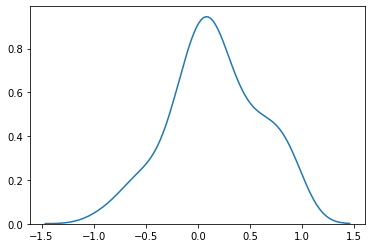

In [55]:
sns.kdeplot(pols_array[3])

In [57]:
tmp = []
seg_aspect_map = {}
with open('data/gold/aspects/boots-dev.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspect_lst = aspect.strip().split()
                seg_aspect_map[text] = aspects[int(aspect_lst[0])]
            tmp = []
tmp = []   
with open('data/gold/aspects/boots-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspect_lst = aspect.strip().split()
                seg_aspect_map[text] = aspects[int(aspect_lst[0])]
            tmp = []

In [59]:
from rouge import Rouge 
rouge = Rouge()
scores_1 = []
scores_2 = []
scores_l = []
for d in data:
    prod_id, text = d
    print(prod_id)
    res = generate_summary(text)
    for s in res:
        probs1, classes1 = generate_aspect(aspect_model, s)
        print((s, seg_aspect_map[s], aspect_label_vocab[classes1]))
    
    ref_B = []
    with open('./data/gold/summaries/boots/all/boots.'+ prod_id +'.E.all.txt', 'r') as f:
        for line in f:
            ref_B.append(line.rstrip())
    score_B = rouge.get_scores(' '.join(res), ' '.join(ref_B))[0]
    
    scores_1.append(score_B['rouge-1']['f'])
    scores_2.append(score_B['rouge-2']['f'])
    scores_l.append(score_B['rouge-l']['f'])
    
    ref_J = []
    with open('./data/gold/summaries/boots/all/boots.'+ prod_id +'.J.all.txt', 'r') as f:
        for line in f:
            ref_J.append(line.rstrip())
    score_J = rouge.get_scores(' '.join(res), ' '.join(ref_J))[0]
    scores_1.append(score_J['rouge-1']['f'])
    scores_2.append(score_J['rouge-2']['f'])
    scores_l.append(score_J['rouge-l']['f'])
    
    ref_M = []
    with open('./data/gold/summaries/boots/all/boots.'+ prod_id +'.N.all.txt', 'r') as f:
        for line in f:
            ref_M.append(line.rstrip())
    score_M = rouge.get_scores(' '.join(res), ' '.join(ref_M))[0]
    """
    print(text)
    print()
    print(res)
    print()
    print(ref_B)
    print()
    print(ref_J)
    print()
    print(ref_M)
    print()
    print()
    """
    scores_1.append(score_M['rouge-1']['f'])
    scores_2.append(score_M['rouge-2']['f'])
    scores_l.append(score_M['rouge-l']['f'])

B000BNRWFW
('They are very comfortable', 'Comfort', 'Comfort')
('They look great, seem to be well made, however,', 'Look', 'Look')
('is super soft unlike the way they were made.', 'Materials', 'Materials')
('where the tongue is sewn to the top of boot.', 'Comfort', 'Materials')
('There was some dried glue', 'Materials', 'Materials')
('Good for the snow too.', 'Weather_resistance', 'Weather_resistance')
B000GAUOHS
('These are very comfortable & attractive boots for my office environment.', 'Comfort', 'Comfort')
('They fit perfectly', 'Comfort', 'Comfort')
('They are really comfortable', 'Comfort', 'Comfort')
('These boots have a sturdy, comfortable sole with a heel', 'Comfort', 'Materials')
('Great boots for the money!', 'Price', 'Price')
('Otherwise, it is a nice looking boot for the price.', 'Price', 'Look')
('and ample toe room,', 'Size', 'Size')
('but were clearly very cheaply made.', 'Durability', 'Materials')
('They seems comfy', 'Comfort', 'Comfort')
('I can wear them all day at 

In [60]:
sum(scores_1)/len(scores_1)

0.4483588811698024

In [61]:
sum(scores_2)/len(scores_2)

0.26302356735075455

In [62]:
sum(scores_l)/len(scores_l)

0.43016173644983874

In [30]:
sum(scores_1)/len(scores_1)

0.3921408548995746

In [31]:
sum(scores_2)/len(scores_2)

0.198859854709762

In [32]:
sum(scores_l)/len(scores_l)

0.3747833671084038

In [25]:
from collections import defaultdict
tmp = []
sal_data = defaultdict(list)
with open('data/gold/aspects/boots-dev.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspects = aspect.split()
                sal_data[product_id].append(text)
                #sal_data[product_id].append((text, aspects[0]))
            tmp = []

with open('data/gold/aspects/boots-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspects = aspect.split()
                sal_data[product_id].append(text)
                #sal_data[product_id].append((text, aspects[0]))
            tmp = []

sal_data = sorted(list(sal_data.items()), key=lambda x: x[0])

In [42]:
def generate_sal_labels(segments):
    tmp = []
    for i, seg in enumerate(segments):
        probs1, classes1 = generate_aspect(aspect_model, seg)
        #print(seg)
        #print(probs1)
        #print(aspect_label_vocab[classes1])
        polarity = generate_sentiment(senti_model, seg)
        #print(probs2)
        #print(sentiment_label_vocab[classes2])
        #print()
        if aspect_label_vocab[classes1] == 'None':
            aspect_score = 0
        else:
            aspect_score = max(probs1[1:])-probs1[0]
        senti_score = abs(polarity)
        if senti_score < 0.5:
            senti_score = 0
        tmp.append((aspect_score*senti_score, seg, i))
    res = sorted(tmp, key=lambda x: x[0], reverse=True)
    weights, sents, indices = map(list, zip(*res))
    return indices

In [43]:
labels_a = defaultdict(list)
labels_b = defaultdict(list)
labels_c = defaultdict(list)
with open('data/gold/salience/boots.sal', 'r') as f:
    idx = 0
    prev_prod = None
    for line in f:
        id_, label = line.split("\t")
        ids = id_.split("-")
        label_lst = list(map(int,label.split()))
        product_id = ids[0]
        if prev_prod != product_id:
            idx = 0
        labels_a[product_id].append((idx, label_lst[0]))
        labels_b[product_id].append((idx, label_lst[1]))
        labels_c[product_id].append((idx, label_lst[2]))
        idx+=1
        prev_prod = product_id
        

In [44]:
len(sal_data)

10

In [45]:
rankings = defaultdict(list)
for d in sal_data:
    product_id, segs = d
    indices = generate_sal_labels(segs)
    rankings[product_id] = indices

In [46]:
def precision_at_n(n, labels):
    ones = 0
    for i in range(n):
        if labels[i] == 1:
            ones+=1
    return ones*1.0/n

In [47]:
precisions = []
p_at_5s = []
for prod_id in rankings.keys():
    ranking = rankings[prod_id]
    label_a = labels_a[prod_id]
    label_b = labels_b[prod_id]
    label_c = labels_c[prod_id]
    sorted_label_a = sorted(label_a, key=lambda x: ranking.index(x[0]))
    sorted_label_b = sorted(label_b, key=lambda x: ranking.index(x[0]))
    sorted_label_c = sorted(label_c, key=lambda x: ranking.index(x[0]))
    _, sorted_a = map(list, zip(*sorted_label_a))
    _, sorted_b = map(list, zip(*sorted_label_b))
    _, sorted_c = map(list, zip(*sorted_label_c))
    p_at_5_a = precision_at_n(5, sorted_a)
    p_at_5_b = precision_at_n(5, sorted_b)
    p_at_5_c = precision_at_n(5, sorted_c)
    p_at_5s.append(p_at_5_a)
    p_at_5s.append(p_at_5_b)
    p_at_5s.append(p_at_5_c)
    
    precision_a = 0
    count = 0
    for i in range(len(sorted_a)):
        if (sorted_a[i] == 1):
            p_at_i = precision_at_n(i+1, sorted_a)
            precision_a+=p_at_i
            count += 1
    precisions.append(precision_a/count)
    
    precision_b = 0
    count = 0
    for i in range(len(sorted_b)):
        if (sorted_b[i] == 1):
            p_at_i = precision_at_n(i+1, sorted_b)
            precision_b+=p_at_i
            count += 1
    precisions.append(precision_b/count)
        
    precision_c = 0
    count = 0
    for i in range(len(sorted_c)):
        if (sorted_c[i] == 1):
            p_at_i = precision_at_n(i+1, sorted_c)
            precision_c+=p_at_i
            count += 1
    precisions.append(precision_c/count)
        

In [48]:
sum(precisions)/len(precisions)  #0.32

0.31410332777866984

In [49]:
sum(p_at_5s)/len(p_at_5s)   #0.69

0.27333333333333343

In [1180]:
data1 = defaultdict(list)
tmp = []
aspects_label = []
with open('data/gold/aspects/bags_and_cases-tst.asp', 'r') as f:
    aspects = f.readline().rstrip().split('|')
    aspects_label = aspects[:]
    #print(aspects)
    f.readline()
    for line in f:
        if line != '\n':
            tmp.append(line.rstrip())
        else:
            id_ = tmp[0]
            product_id = id_.split('-')[0]
            for text_data in tmp[1:]:
                text, aspect = text_data.strip().split('\t')
                aspects = aspect.split()
                data1[product_id].append((text, aspects_label[int(aspects[0])]))
            tmp = []

#data1 = sorted(list(data1.items()), key=lambda x: x[0])

In [1181]:
data2 = defaultdict(list)

with open('data/gold/polarities/bags_and_cases.pol', 'r') as f:
    for line in f:
        id_, pol = line.split('\t')
        prod_id = id_.split('-')[0]
        data2[prod_id].append(float(pol))
        
#data2 = sorted(list(data2.items()), key=lambda x: x[0])

In [1182]:
data3 = defaultdict(list)
for k in data2:
    if k in data1:
        for asp, pol in zip(data1[k], data2[k]):
            data3[k].append((asp[0], asp[1], pol))

In [1183]:
review_ids = set()
with open('data/gold/polarities/bags_and_cases.pol', 'r') as f:
    for line in f:
        id_, pol = line.split('\t')
        prod_id = id_.split('-')[0]
        review_id = id_.split('-')[1]
        review_ids.add('-'.join([prod_id, review_id]))

In [1184]:
labels_a = defaultdict(list)
labels_b = defaultdict(list)
labels_c = defaultdict(list)
with open('data/gold/salience/bags_and_cases.sal', 'r') as f:
    idx = 0
    prev_prod = None
    for line in f:
        id_, label = line.split("\t")
        ids = id_.split("-")
        label_lst = list(map(int,label.split()))
        product_id = ids[0]
        review_id = '-'.join(ids[:2])
        if review_id not in review_ids:
            continue
        if prev_prod != product_id:
            idx = 0
        labels_a[product_id].append((idx, label_lst[0]))
        labels_b[product_id].append((idx, label_lst[1]))
        labels_c[product_id].append((idx, label_lst[2]))
        idx+=1
        prev_prod = product_id

In [1185]:
infos = defaultdict(list)
for prod_id in data3:
    for seg, asp_label, pol_label in data3[prod_id]:
        probs1, classes1 = generate_aspect(aspect_model, seg)
        #print(seg)
        #print(probs1)
        #print(aspect_label_vocab[classes1])
        polarity = generate_sentiment(senti_model, seg)
        senti_score = polarity
        
        infos[prod_id].append((seg, asp_label, max(probs1), aspect_label_vocab[classes1], pol_label , senti_score))
        
        
        

In [1186]:
rankings2 = defaultdict(list)
for pid in infos:
    tmp = []
    i = 0
    for d in infos[pid]:
        seg, asp_label, asp_score, pred_asp, pol, pred_pol = d
        tmp.append((asp_score*pol, seg, i))
        i+=1
    res = sorted(tmp, key=lambda x: x[0], reverse=True)
    weights, sents, indices = map(list, zip(*res))
    rankings2[pid] = indices

In [1187]:
labels = []
preds = []
for prod_id in data1:
    for d in data1[prod_id]:
        seg, asp_label = d
        labels.append(asp_label)
        probs1, classes1 = generate_aspect(aspect_model, seg)
        preds.append(aspect_label_vocab[classes1])
            

In [1188]:
from sklearn import metrics
print(metrics.precision_score(labels, preds, average='weighted'))
print(metrics.recall_score(labels, preds, average='weighted'))
print(metrics.f1_score(labels, preds, average='weighted'))

0.661314578436625
0.6401225114854517
0.6385238337331397


In [1189]:
total = 0
correct = 0
accurate = 0
real_pols = []
pred_pols = []
errs = []
for prod_id in infos:
    for d in infos[prod_id]:
        total+=1
        if abs(d[4] - d[5]) <= 0.3:
            accurate += 1
        real_pols.append(d[4])
        pred_pols.append(d[5])
        errs.append(abs(d[4]-d[5]))
        print(d[4] - d[5])
        if (d[4] >0 ) == (d[5]>0):
            correct+=1
            

-0.09761678385734558
-0.46048312950134274
-0.05533921861648561
0.07756399679183956
-0.06120340815186501
0.09991502332687374
0.08535843026638032
-0.25933528232574465
0.12297663894295693
0.12652857291698455
-0.6228244112730026
-0.49953490924835203
0.06255666625499726
0.0615368173122406
-0.1524324394464493
-0.5142392610609532
-0.05074849295616152
-0.35060742688179014
-0.4496952352523804
-0.1202917801141739
-0.416976301908493
0.25874162006378176
0.005710849404335021
-0.5459254203438759
-1.5944239511489868
-0.2811607956290245
-0.1465512605905533
-0.3154029221534729
-0.5846862154006958
-0.2577015190124512
0.2012702510356903
-0.11992101994156837
0.2913613262176514
-0.5777764930725098
-0.4172896475791931
-0.2845917152166367
-0.48656415510177614
-0.6119029505308717
0.25967632234096527
-0.7996231956481934
-0.24212316498160363
-0.8228810472488404
-0.5695583565235138
-0.17359171521663666
-0.17322789132595062
0.5931509439945221
-0.26733637328445914
0.07903124380111692
-0.680371883392334
0.273660302

In [1190]:
correct/total

0.6767123287671233

In [1191]:
accurate/total

0.536986301369863

In [1192]:
total

365

In [1193]:
x = range(len(real_pols))

In [1194]:
y1 = real_pols
y2 = pred_pols

In [1195]:
import matplotlib.pyplot as plt


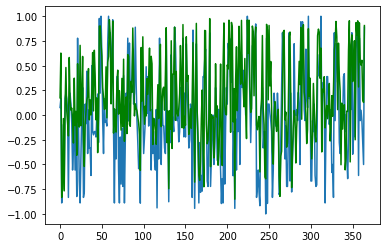

In [1196]:
plt.plot(x,y1)
plt.plot(x,y2,color='green')

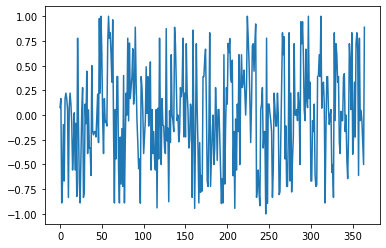

In [1197]:
plt.plot(x,y1)

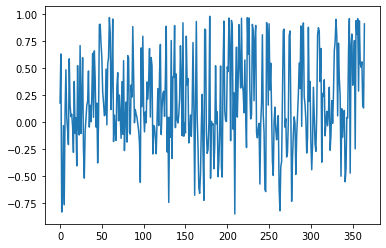

In [1198]:
plt.plot(x,y2)

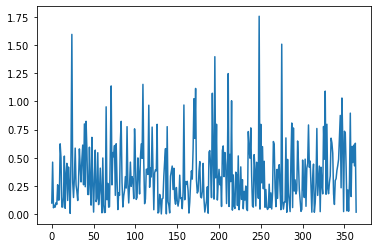

In [1199]:
plt.plot(x,errs)